In [1]:
# Necessary imports
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import glob
import re
from IPython.display import Image 
from IPython.core.display import HTML 
import nltk
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from time import time
import matplotlib.pyplot as plt
import random
from textblob import TextBlob
import re

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

import plotly.graph_objs as go
from chart_studio import plotly
import cufflinks
pd.options.display.max_columns = 30
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='polar')
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()
from collections import Counter
import scattertext as st
import spacy
from pprint import pprint
import en_core_web_sm

print('Libraries imported!')

Loading BokehJS ...

Libraries imported!


In [2]:
import random

random.seed(42)


sw = ['medium', 'color', 'colors', 'aroma', 'aromas', 'flavor', 'flavors', 'review', 'taste', 'tasting', 'pair', 'pairing', 'oz', 'simple', 'dash', 'bsp', 'drops']
stop_words = ENGLISH_STOP_WORDS.union(sw)


def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens

def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub(r'[^\w\s]','',each) for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    #text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def text_cleaning(texts):
    #lowercase
    texts = texts.apply(lambda x: x.lower())

    #Remove puntuations
    texts = texts.apply(lambda x: re.sub(r'[^\w\s]','',x))

    #Remove numbers
    texts = texts.apply(lambda x: re.sub(r'\d+', '', x))
    
    return texts

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

### TFIDF - NMF

In [3]:
df = pd.read_csv('../data/extended_df.csv', index_col=0)

In [4]:
descriptions = df['Description'].fillna('') + ' ' + df['Price_Range'].fillna('')

descriptions = text_cleaning(descriptions)

tfidf_des = TfidfVectorizer(stop_words=stop_words,
                           min_df=3,
                           max_df=0.7) #tfidf vectorizer: used to transform new text data to to through the nmf

des_matrix = tfidf_des.fit_transform(descriptions)

vocabs_des = tfidf_des.get_feature_names()

nmf_des = NMF(10)

des_matrix = nmf_des.fit_transform(des_matrix) #nmf model to transform new text data

des_df = pd.DataFrame(des_matrix).add_prefix('topic_')

des_df['Description'] = df['Description']

des_df.tail()

topic_0   topic_1   topic_2   topic_3   topic_4   topic_5  topic_6  \
11773  0.002320  0.001724  0.000817  0.000000  0.035942  0.000000      0.0   
11774  0.001834  0.003604  0.002761  0.000000  0.043738  0.000000      0.0   
11775  0.000000  0.004799  0.001538  0.016161  0.000000  0.000000      0.0   
11776  0.001848  0.012546  0.001432  0.001144  0.000000  0.000089      0.0   
11777  0.000000  0.012139  0.002247  0.029976  0.000000  0.000098      0.0   

       topic_7   topic_8  topic_9  \
11773      0.0  0.016789      0.0   
11774      0.0  0.000000      0.0   
11775      0.0  0.027252      0.0   
11776      0.0  0.000239      0.0   
11777      0.0  0.000000      0.0   

                                             Description  
11773  Champagne Armand de Brignac Blanc de Noirs Ass...  
11774  In 1974, 100 years after the creation of Crist...  
11775  Variety\n\n\nSangiovese, Cabernet Sauvignon\n\...  
11776  Variety\n\n\n\nGrechetto\n\n\n\nGrowing method...  
11777  Our Cabernets are a blend of wines from eight ...

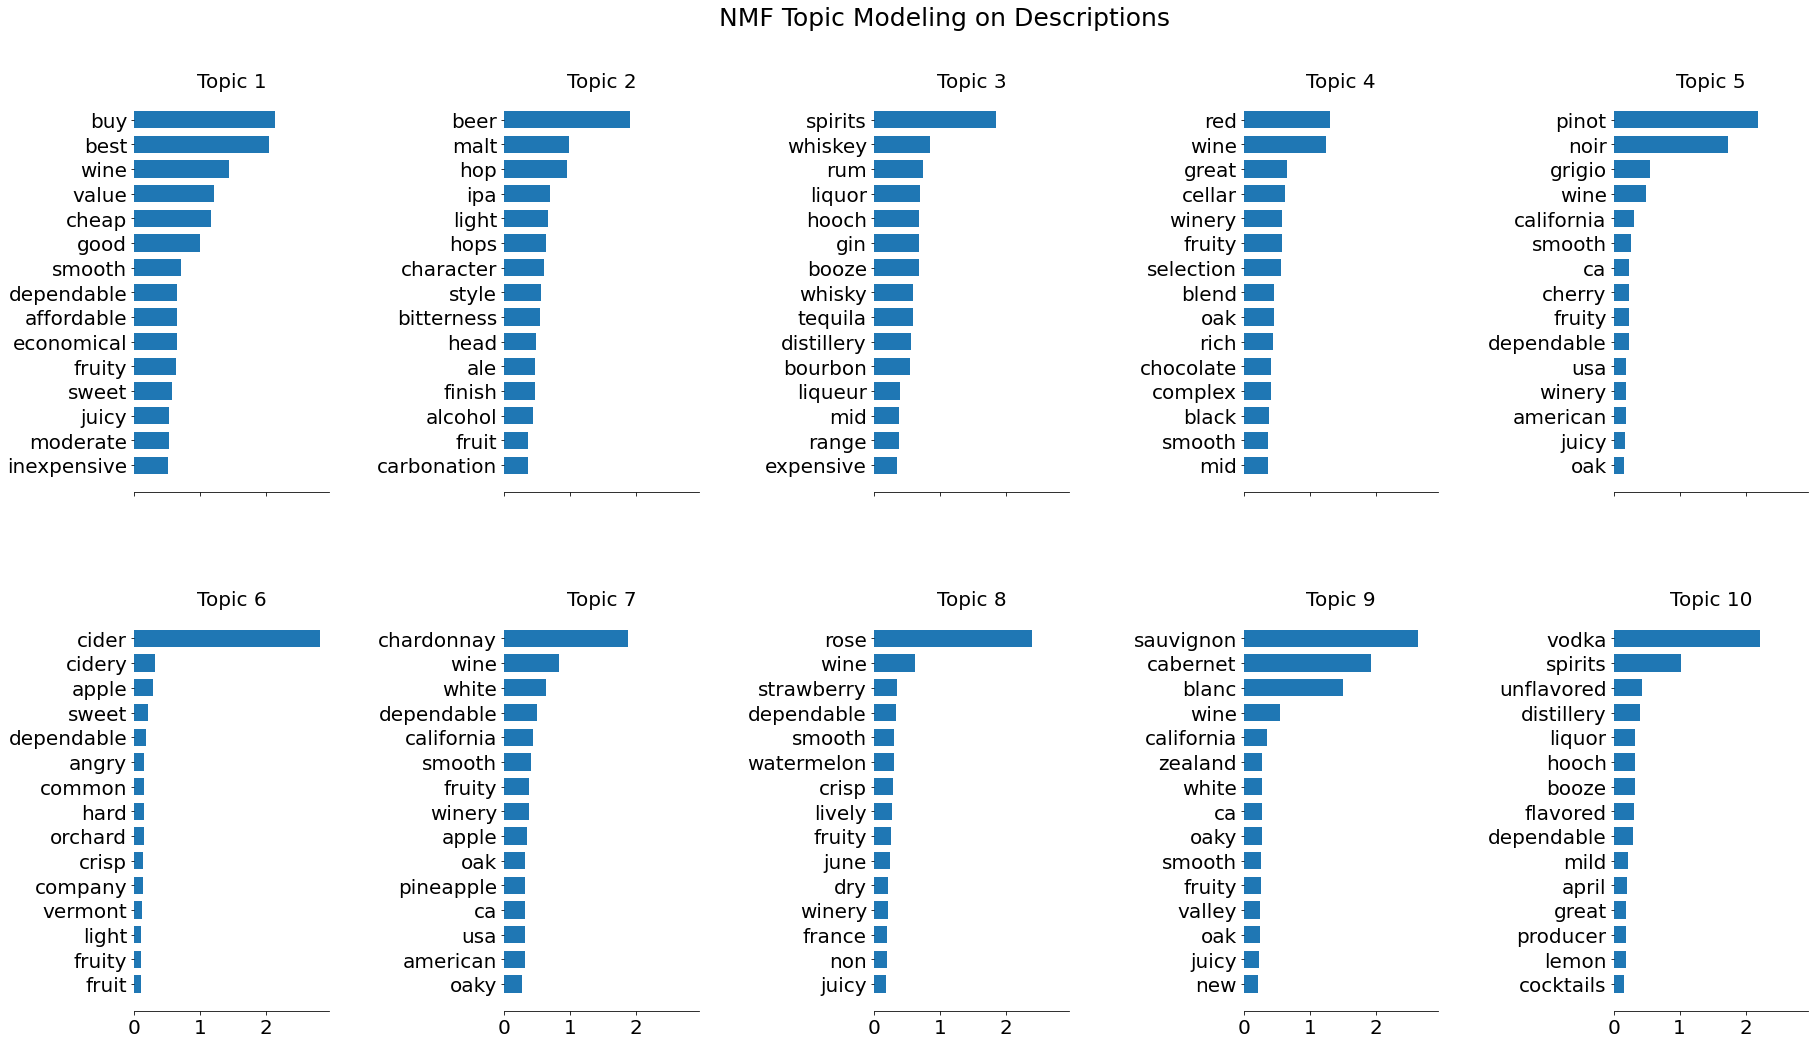

In [5]:
plot_top_words(nmf_des, vocabs_des, 15, "NMF Topic Modeling on Descriptions")

In [6]:
des_word_df = pd.DataFrame(nmf_des.components_.round(5), columns=vocabs_des).T.add_prefix('topic_')

In [7]:
categories_by_descriptions = {
    'topic_0': 'cheap, affordable, and good value',
    'topic_1': 'beer (lager and ipa)',
    'topic_2': 'whiskey, rum, tequila',
    'topic_3': 'red blend and merlot',
    'topic_4': 'red pinot noir',
    'topic_5': 'sweet cider',
    'topic_6': 'white chardonnay',
    'topic_7': 'rose',
    'topic_8': 'red cabernet sauvignon',
    'topic_9': 'vodka and spirits'
}

In [8]:
for description in des_df.sort_values(by='topic_9', ascending=False).head(10)['Description'].values:
    print(description)
    print('\n')
des_word_df.sort_values(by='topic_9', ascending=False).head(10).topic_9

Our Los Angeles Vodka Review CA California USA US Spirits Unflavored Vodka 233764 Vodka Spirits Tasting Note Flavor Description Mild Tingling Dryish fresh lemon zest Same as aromas with impressions of minerals and water crackers A citrusy Vodka that will work well in fruity shaken cocktails Silver Medal March 2021 Rating $32 88 Points Premium Price Special Occasion Spendy American Our Vodka Liquor Booze Hooch Dependable Spirits Producer Dependable Distillery


Townes Review Vodka TX Texas USA US Spirits Unflavored Vodka 230154 Vodka Spirits Tasting Note Flavor Description Mild Hot Dry minerals A peppery vodka that packs punch; solid Bloody Mary vodka Bronze Medal December 2019 Rating $1299 84 Points Moderate Price Affordable Economical American Dynasty Spirits Liquor Booze Hooch


NEFT Review Vodka Austria Austrian Spirits Unflavored Vodka 230754 Vodka Spirits Tasting Note Flavor Description Mild Smooth Dry linen stone white flowers and cream of wheat Same as aromas with elements of cr

vodka         2.21546
spirits       1.02094
unflavored    0.42254
distillery    0.39830
liquor        0.33007
hooch         0.32869
booze         0.32802
flavored      0.31260
dependable    0.29561
mild          0.22014
Name: topic_9, dtype: float64

### Sentiment analysis

In [9]:
df['Full_Review'] = df['Review'] + ' ' + df['Extend_Review']
df['Full_Review'].fillna('', inplace=True)
reviews = df['Full_Review']
reviews = text_cleaning(reviews)

In [10]:
df['polarity'] = df['Full_Review'].map(lambda text: TextBlob(text).sentiment.polarity)

In [11]:
df.polarity.describe()

count    11778.000000
mean         0.103180
std          0.101533
min         -0.142188
25%          0.000000
50%          0.100964
75%          0.186792
max          0.558333
Name: polarity, dtype: float64

In [12]:
print('5 reviews with the highest positive sentiment polarity: \n')
for review in df.sort_values(by='polarity', ascending=False).head(5).Full_Review:
    print(review)
    print('\n')

5 reviews with the highest positive sentiment polarity: 

Gold color. Interesting aromas of warm corn bread, sweet plantains, cola nut, toffee cookies, and caramelized vegetables with a satiny, vibrant, dry-yet-fruity medium body and a warming, interesting, medium-long tahini, wintergreen, alpine herbs, and lemon verbena finish. A distinctively flavored rum with bright spices and herbaceous cane notes; a one-of-a-kind ingredient for cocktails with a sophisticated vibe. Fresh cane juice rums are made with fresh sugar cane juice instead of molasses, but are not AOC or DO products, such as Martinique Rhum, Haitian Rhum or Cachaça. These are often of excellent quality with nutty, spicy flavors and a tangy finish and are perfect for cocktails or with the best examples, ideal as a sipping rum.


Silvery emerald straw color. Aromas and flavors of lychee, roasted peach, and pencil with a bright, moderately sweet medium body and a buoyant finish evoking shades of meringue and hint of gum with f

In [13]:
print('3 reviews with the lowest sentiment polarity: \n')
for review in df.sort_values(by='polarity').head(3).Full_Review:
    print(review)
    print('\n')

3 reviews with the lowest sentiment polarity: 

Tasted as a Bloody Mary cocktail. Red color. Aromas of marinara, pizza crust, sweetie drop peppers, and mozzarella with a thick, crisp, salty medium body and a warming, medium-length caper brine and sweet and sour sauce finish. A solid Bloody. Long a staple at weekend brunches, a Bloody Mary is a cocktail made from vodka, tomato juice and several other spice and flavorings including Worcestershire sauce, Tabasco sauce and horseradish, to name just a few. Celery salt or a stalk of celery are often added. The color of the drink is deep red, hence the name. It has been celebrated in folklore and literature since the 1920s.


Dusty garnet black color. Aromas of grilled berries, graphite, cedar, and clove with a satiny, racy, dryish medium body and a snappy smoked meats, tart cassis, tiramisu, and tart oranges finish with moderate oak flavor. A smoky, perky Bordeaux for the table. A small Bordeaux commune in the Haut Medoc appellation known fo

### EDA

#### Distribution of polarity

In [14]:
df['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

#### Distribution of Price, Points

In [15]:
df['Price'].iplot(
    kind='hist',
    xTitle='price ($)',
    linecolor='black',
    yTitle='count',
    title='Price Distribution')

In [16]:
df['Points'].iplot(
    kind='hist',
    xTitle='point',
    linecolor='black',
    yTitle='count',
    title='Points Distribution')

In [17]:
df['Medal'].iplot(
    kind='hist',
    xTitle='medal',
    linecolor='black',
    yTitle='count',
    title='Points Distribution')

In [18]:
df['Bands'].iplot(
    kind='hist',
    xTitle='bands',
    linecolor='black',
    yTitle='count',
    title='Points Distribution')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11778 entries, 0 to 11777
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            11778 non-null  object 
 1   Description     11775 non-null  object 
 2   Category        7322 non-null   object 
 3   Country         9705 non-null   object 
 4   Alcohol_Vol     7322 non-null   object 
 5   Review          10778 non-null  object 
 6   Style           7286 non-null   object 
 7   Aroma           9700 non-null   object 
 8   Flavor          9698 non-null   object 
 9   Sweetness       5225 non-null   object 
 10  Bitterness      438 non-null    object 
 11  Enjoy           7303 non-null   object 
 12  Pairing         5509 non-null   object 
 13  Cocktails       1315 non-null   object 
 14  Bottom_Line     7322 non-null   object 
 15  Points          6224 non-null   float64
 16  Price           7546 non-null   float64
 17  Points_Ranking  6224 non-null  

In [20]:
trace1 = go.Scatter(
        x=df['polarity'], y=df['Bands_Rank'], mode='markers', name='points',
    marker=dict(color='rgb(102,0,0)', size=2, opacity=0.4)
)
trace2 = go.Histogram2dContour(
        x=df['polarity'], y=df['Bands_Rank'], name='density', ncontours=20,
    colorscale='Hot', reversescale=True, showscale=False
)
trace3 = go.Histogram(
    x=df['polarity'], name='Sentiment polarity density',
    marker=dict(color='rgb(102,0,0)'),
    yaxis='y2'
)
trace4 = go.Histogram(
        y=df['Bands_Rank'], name='Rating density', marker=dict(color='rgb(102,0,0)'),
    xaxis='x2'
)
data = [trace1, trace2, trace3, trace4]

layout = go.Layout(
    showlegend=False,
    autosize=False,
    width=600,
    height=550,
    xaxis=dict(
        domain=[0, 0.85],
        showgrid=False,
        zeroline=False
    ),
    yaxis=dict(
        domain=[0, 0.85],
        showgrid=False,
        zeroline=False
    ),
    margin=dict(
        t=50
    ),
    hovermode='closest',
    bargap=0,
    xaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    ),
    yaxis2=dict(
        domain=[0.85, 1],
        showgrid=False,
        zeroline=False
    )
)

fig = go.Figure(data=data, layout=layout)
iplot(fig, filename='2dhistogram-2d-density-plot-subplots')

#### Distributionf of words

In [21]:
#1 n-gram
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Full_Review'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['Full_Review' , 'count'])

wines 9577
red 8461
finish 8228
wine 7983
body 7761
oak 6972
cabernet 6566
light 6529
dry 5653
fruity 5578
sauvignon 5490
examples 5120
pinot 5017
fruit 4941
california 4755
years 4343
notes 4113
long 3977
aged 3974
black 3903


In [22]:
#bigram
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(df['Full_Review'], 20)
for word, freq in common_words:
    print(word, freq)
df4 = pd.DataFrame(common_words, columns = ['Full_Review' , 'count'])

cabernet sauvignon 4406
light body 3496
pinot noir 2947
fruity body 2235
dry fruity 2041
body smooth 1930
fruity light 1631
moderate oak 1452
long finish 1350
length finish 1305
oak barrels 1283
cabernet franc 1177
red wine 1061
sauvignon blanc 1054
body tingling 1015
california especially 955
quite rich 949
satiny crisp 947
pinot noirs 947
new zealand 946


In [23]:
df4.groupby('Full_Review').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in review after removing stop words')

In [24]:
#trigrams

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words=stop_words).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(df['Full_Review'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['Full_Review' , 'count'])

fruity light body 1630
dry fruity body 1144
light body smooth 1126
small oak barrels 880
dry fruity light 871
tannins moderate oak 773
dryish light body 771
russian river valley 739
vibrant dry fruity 637
pinot noirs tend 620
crisp dry fruity 593
rich red meats 567
dry light body 552
longest lived reds 549
black cherry plum 548
maipo colchagua valleys 547
colchagua valleys chile 547
great aging potential 532
wines cabernet sauvignon 521
cabernet sauvignon variety 520


In [25]:
df5.groupby('Full_Review').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in review before removing stop words')

#### POS

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tqluo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [27]:
!python -m textblob.download_corpora

Finished.


[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\tqluo\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tqluo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tqluo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tqluo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\tqluo\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\tqluo\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!

In [28]:
blob = TextBlob(str(df['Full_Review']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.iplot(
    kind='bar',
    xTitle='POS',
    yTitle='count', 
    title='Top 20 Part-of-speech tagging for review corpus')